In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ml_datasets.esl import ProstateCancer
from sklearn import preprocessing
from esl.chapter03 import kfold

In [2]:
prostate_cancer = ProstateCancer(verbose=0)

In [3]:
df = prostate_cancer.load()

train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(df_x[train_test=='T'].values)
x_test = scaler.transform(df_x[train_test=='F'].values)

y_train_temp = df_y[train_test=='T'].copy().values
y_train = y_train_temp - np.mean(y_train_temp)

y_test_temp = df_y[train_test=='F'].copy().values
y_test = y_test_temp  - np.mean(y_train_temp)

In [4]:
class PartialLeastSquares:
    def __init__(self, **kwargs):
        self.num_direction = kwargs.get('num_direction', 1)
        
    def fit(self, x, y):
        x_prev = x.copy()
        y_hat_prev = (np.ones_like(y) * np.mean(y))
        z = np.zeros_like(x)
        phi = np.zeros((x.shape[1], x.shape[1]))
        theta = np.zeros(x.shape[1])
        for m in range(1, self.num_direction + 1):
            for j in range(x.shape[1]):
                phi[m - 1, j] = x_prev[:, j].T @ y
                z[:, m - 1] += phi[m - 1, j] * x_prev[:, j]
            
            theta[m - 1] = (z[:, m - 1].T @ y) / (z[:, m - 1].T @ z[:, m - 1])

            y_hat_prev = y_hat_prev + theta[m - 1] * z[:, m - 1]

            for j in range(x.shape[1]):
                x_prev[:, j] = x_prev[:, j] -  ((z[:, m - 1].T @ x_prev[:, j]) / (z[:, m - 1].T @ z[:, m - 1])) * z[:, m - 1]

        self.beta_hat = np.linalg.inv(x.T @ x) @ x.T @ y_hat_prev
   
    def predict(self, x):
        return x @ self.beta_hat
    
    def error(self, x, y):
        y_hat = self.predict(x)
        error = y_hat - y
        
        return error.T @ error, (error.T @ error) / len(error)

In [5]:
x_dict, y_dict = kfold(x_train, y_train, nfold=10, seed=5)
num_directions = np.arange(x_train.shape[1] + 1)
RSS = dict()
MRSS = dict()

for m in num_directions:
    RSS_temp = []
    MRSS_temp = []
    
    for fold in x_dict.keys():
        if m == 0:
            y_train_temp = y_dict[fold]['train'].copy()
            y_val_temp = y_dict[fold]['val'].copy()
            error = (y_val_temp).T @ (y_val_temp)
            merror = error / len(y_val_temp)
            
        else:
            x_train_temp = x_dict[fold]['train'].copy()
            x_val_temp = x_dict[fold]['val'].copy()

            y_train_temp = y_dict[fold]['train'].copy()
            y_val_temp = y_dict[fold]['val'].copy()
            
            pls = PartialLeastSquares(num_direction=m)
            pls.fit(x_train_temp, y_train_temp)
            error, merror = pls.error(x_val_temp, y_val_temp)

        RSS_temp.append(error)
        MRSS_temp.append(merror)
        
    RSS[m] = RSS_temp
    MRSS[m] = MRSS_temp

In [6]:
x_cv = np.array(list(RSS.keys()))

# calculate the mean of MSE from the 10-fold cross validation
y_cv_mean = np.array([np.mean(MRSS[key]) for key in MRSS.keys()])

# calculate the standard error
y_cv_std = np.array([np.std(MRSS[key]) / (10 ** 0.5) for key in MRSS.keys()])

# find the most parsimonious model
upper_bound = np.min(y_cv_mean) + y_cv_std[np.argmin(y_cv_mean)]
best_dir = np.min(np.where(y_cv_mean <= upper_bound)[0])

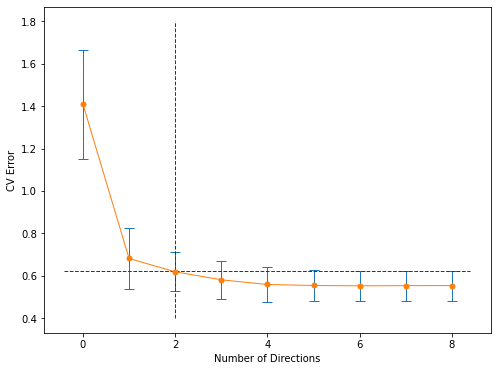

In [7]:
plt.figure(figsize=(8, 6))
plt.errorbar(x_cv, y_cv_mean, yerr=y_cv_std, capsize=5, ecolor='C0', color='C1', elinewidth=1, linewidth=1, marker='o', markersize=5)
x_cvv = np.linspace(-0.4, 8.4, 20)
y_cvv = np.linspace(0.4, 1.8, 20)

# this is to plot the purple horizontal line
plt.plot(x_cvv, upper_bound * np.ones(len(x_cvv)), '--', color='purple', linewidth=1)

# this is to plot the purple vertical line
plt.plot(best_dir * np.ones(len(y_cvv)), y_cvv, '--', color='purple', linewidth=1)

# plt.xlim([-0.4, 8.4])
# plt.ylim([0.45, 1.81])
plt.xlabel('Number of Directions')
plt.ylabel('CV Error')
plt.show()

In [8]:
pls = PartialLeastSquares(num_direction=2)
pls.fit(x_train, y_train)

In [9]:
# calculate the mse and std. error
y_hat = x_test @ pls.beta_hat
error = (y_test - y_hat).T @ (y_test - y_hat)
mse = error / len(y_test)
std_error = np.sqrt(np.var((y_test - y_hat) ** 2) / (len(y_test) - 1))

beta_0 = np.mean(df_y[train_test=='T'].copy().values)
pls_dframe = pd.DataFrame({'PLS': np.append(np.append(beta_0, pls.beta_hat), np.array([mse, std_error]))})
pls_dframe['Term'] = ['Intercept'] + list(prostate_cancer.meta[:-1]) + ['Test Error', 'Std Error']
cols = pls_dframe.columns[::-1]
pls_dframe = pls_dframe[cols].replace(0, '')
pls_dframe.style.\
    hide_index().\
    set_caption('Estimated Coefficients').\
    set_precision(3).\
    apply(lambda x: ['font-weight: bold' if x['Term'] in ['Test Error', 'Std Error'] else '' for i in x], axis=1)

Term,PLS
Intercept,2.452
lcavol,0.433
lweight,0.358
age,-0.021
lbph,0.241
svi,0.257
lcp,0.085
gleason,0.006
pgg45,0.084
Test Error,0.536
